### Generating human faces with Adversarial Networks
[![img](https://www.strangerdimensions.com/wp-content/uploads/2013/11/reception-robot.jpg)](http://payload.cargocollective.com/1/0/17293/393670/HumanTaxidermy01.jpg)

This time we'll train a neural net to generate plausible human faces in all their subtlty: appearance, expression, accessories, etc. 'Cuz when us machines gonna take over Earth, there won't be any more faces left. We want to preserve this data for future iterations. Yikes...

Based on https://github.com/Lasagne/Recipes/pull/94 .


In [0]:
import sys
sys.path.append("..")
import grading
import download_utils

In [0]:
download_utils.link_week_4_resources()

In [0]:
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
setup_google_colab.setup_week4()
!pip install ipywidgets
import ipywidgets

--2018-08-05 23:48:15--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2327 (2.3K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   2.27K  --.-KB/s    in 0s      

2018-08-05 23:48:15 (34.8 MB/s) - ‘setup_google_colab.py’ saved [2327/2327]



In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

from sklearn.datasets import load_digits
#The following line fetches you two datasets: images, usable for autoencoder training and attributes.
#Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import load_lfw_dataset 
data,attrs = load_lfw_dataset(dimx=36,dimy=36)

#preprocess faces
data = np.float32(data)/255.

IMG_SHAPE = data.shape[1:]

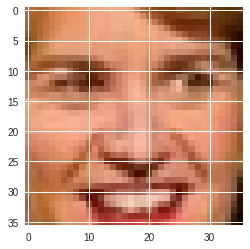

In [0]:
#print random image
plt.imshow(data[np.random.randint(data.shape[0])], cmap="gray", interpolation="none")

# Generative adversarial nets 101

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Deep learning is simple, isn't it? 
* build some network that generates the face (small image)
* make up a __measure__ of __how good that face is__
* optimize with gradient descent :)


The only problem is: how can we engineers tell well-generated faces from bad? And i bet you we won't ask a designer for help. 

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a face sample. 
  * Let's call him __G__(z), where z is a gaussian noize.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake. 
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [0]:
import tensorflow as tf
from keras_utils import reset_tf_session
s = reset_tf_session()

import keras
from keras.models import Sequential
from keras import layers as L

Using TensorFlow backend.


In [0]:
CODE_SIZE = 256

generator = Sequential()
generator.add(L.InputLayer([CODE_SIZE],name='noise'))
generator.add(L.Dense(10*8*8, activation='elu'))

generator.add(L.Reshape((8,8,10)))
generator.add(L.Deconv2D(64,kernel_size=(5,5),activation='elu'))
generator.add(L.Deconv2D(64,kernel_size=(5,5),activation='elu'))
generator.add(L.UpSampling2D(size=(2,2)))
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))

generator.add(L.Conv2D(3,kernel_size=3,activation=None))


In [0]:
assert generator.output_shape[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE,generator.output_shape[1:])

### Discriminator
* Discriminator is your usual convolutional network with interlooping convolution and pooling layers
* The network does not include dropout/batchnorm to avoid learning complications.
* We also regularize the pre-output layer to prevent discriminator from being too certain.

In [0]:
discriminator = Sequential()

discriminator.add(L.InputLayer(IMG_SHAPE))

#<build discriminator body>
discriminator.add(L.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
discriminator.add(L.MaxPool2D(pool_size=3, strides=2, padding="same"))
discriminator.add(L.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
discriminator.add(L.MaxPool2D(pool_size=3, strides=2, padding="same"))
discriminator.add(L.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
discriminator.add(L.MaxPool2D(pool_size=3, strides=2, padding="same"))
discriminator.add(L.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"))
discriminator.add(L.MaxPool2D(pool_size=3, strides=2, padding="same"))
discriminator.add(L.Flatten())
discriminator.add(L.Dense(256,activation='tanh'))
discriminator.add(L.Dense(2,activation=tf.nn.log_softmax))


Instructions for updating:
keep_dims is deprecated, use keepdims instead


# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real
* Since discriminator is a differentiable neural network, we train both with gradient descent.

![img](https://s24.postimg.org/cw4nognxx/gan.png)

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* Regularize discriminator output weights to prevent explosion
* Train generator with __adam__ to speed up training. Discriminator trains with SGD to avoid problems with momentum.
* More: https://github.com/soumith/ganhacks


In [0]:
noise = tf.placeholder('float32',[None,CODE_SIZE])
real_data = tf.placeholder('float32',[None,]+list(IMG_SHAPE))

logp_real = discriminator(real_data)

generated_data = generator(noise)

logp_gen = discriminator(generated_data)



In [0]:
########################
#discriminator training#
########################

d_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])

#regularize
d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)

#optimize
disc_optimizer =  tf.train.GradientDescentOptimizer(1e-3).minimize(d_loss,var_list=discriminator.trainable_weights)

In [0]:
########################
###generator training###
########################

g_loss = -tf.reduce_mean(logp_gen[:,1]) + tf.reduce_mean(generator.layers[1].kernel**2)

gen_optimizer = tf.train.AdamOptimizer(1e-4).minimize(g_loss,var_list=generator.trainable_weights)
    

In [0]:
s.run(tf.global_variables_initializer())

In [0]:
saver = tf.train.Saver()

### Auxiliary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [0]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow,ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray")
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

### Training
Main loop.
We just train generator and discriminator in a loop and plot results once every N iterations.

In [19]:
from IPython import display
from tqdm import tnrange

for epoch in tnrange(50000):
    
    feed_dict = {
        real_data:sample_data_batch(100),
        noise:sample_noise_batch(100)
    }
    
    for i in range(5):
        s.run(disc_optimizer,feed_dict)
    
    s.run(gen_optimizer,feed_dict)
    
    if epoch %100==0:
        print(epoch)
        display.clear_output(wait=True)
        sample_images(2,3,True)
        sample_probas(1000)
    if epoch % 10000==0:
        save_path = saver.save(s, "./model" + str(epoch) + ".ckpt")
        

KeyboardInterrupt: ignored

In [21]:
from submit_honor import submit_honor
submit_honor((generator, discriminator), "frankji.cbb@gmail.com", "uCmB95JLEENK1bWV")

Submitted to Coursera platform. See results on assignment page!


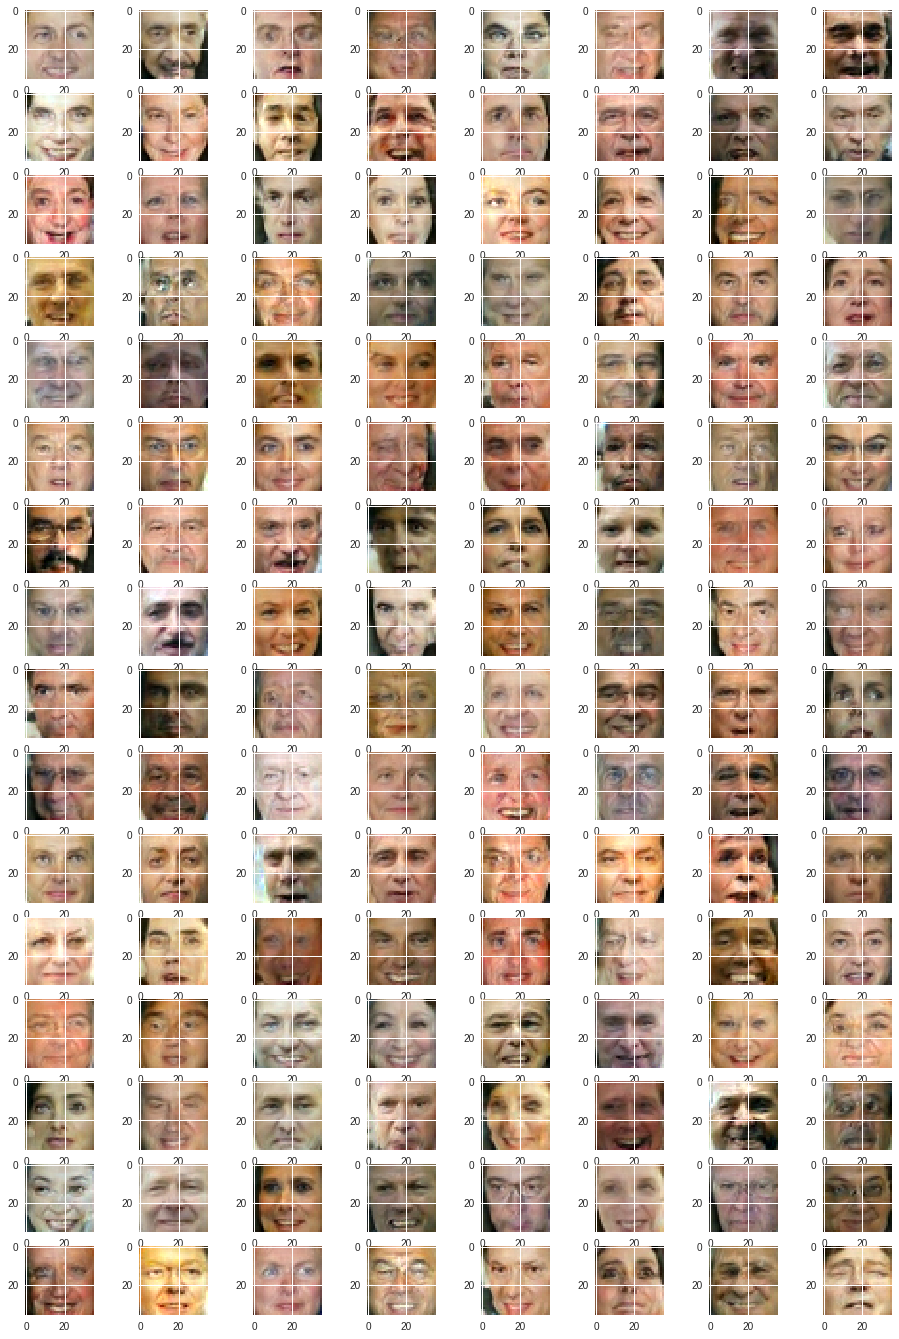

In [20]:
#The network was trained for about 15k iterations. 
#Training for longer yields MUCH better results
plt.figure(figsize=[16,24])
sample_images(16,8)